In [1]:
%matplotlib inline

In [2]:
import LFPy
import numpy as np
import os
import sys
from urllib.request import urlopen
import ssl
import zipfile
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from os.path import join

--------------------------------------------------------------------------
The library attempted to open the following supporting CUDA libraries,
but each of them failed.  CUDA-aware support is disabled.
libcuda.so.1: cannot open shared object file: No such file or directory
libcuda.dylib: cannot open shared object file: No such file or directory
/usr/lib64/libcuda.so.1: cannot open shared object file: No such file or directory
/usr/lib64/libcuda.dylib: cannot open shared object file: No such file or directory
If you are not interested in CUDA-aware support, then run with
--mca opal_warn_on_missing_libcuda 0 to suppress this message.  If you are interested
in CUDA-aware support, then try setting LD_LIBRARY_PATH to the location
of libcuda.so.1 to get passed this issue.
--------------------------------------------------------------------------


In [3]:


if not os.path.isfile(join('cells', 'cells', 'j4a.hoc')):
    #get the model files:
    u = urlopen('http://senselab.med.yale.edu/ModelDB/eavBinDown.asp?o=2488&a=23&mime=application/zip',
                context=ssl._create_unverified_context())
    localFile = open('patdemo.zip', 'wb')
    localFile.write(u.read())
    localFile.close()
    #unzip:
    myzip = zipfile.ZipFile('patdemo.zip', 'r')
    myzip.extractall('.')
    myzip.close()



In [4]:
# Define cell parameters
cell_parameters = {
    'morphology' : join('cells', 'cells', 'j4a.hoc'), # from Mainen & Sejnowski, J Comput Neurosci, 1996
    'cm' : 1.0,         # membrane capacitance
    'Ra' : 150.,        # axial resistance
    'v_init' : -65.,    # initial crossmembrane potential
    'passive' : True,   # turn on NEURONs passive mechanism for all sections
    'passive_parameters' : {'g_pas' : 1./30000, 'e_pas' : -65},
    'nsegs_method' : 'lambda_f', # spatial discretization method
    'lambda_f' : 100.,           # frequency where length constants are computed
    'dt' : 2.**-3,      # simulation time step size
    'tstart' : 0.,      # start time of simulation, recorders start at t=0
    'tstop' : 100.,     # stop simulation at 100 ms.
}

# Create cell
cell = LFPy.Cell(**cell_parameters)
# Align cell
cell.set_rotation(x=4.99, y=-4.33, z=3.14)

In [5]:


# Define synapse parameters
synapse_parameters = {
    'idx' : cell.get_closest_idx(x=-200., y=0., z=1600.),
    'e' : 0.,                   # reversal potential
    'syntype' : 'ExpSyn',       # synapse type
    'tau' : 5.,                 # synaptic time constant
    'weight' : .001,            # synaptic weight
    'record_current' : True,    # record synapse current
}

# Create synapse and set time of synaptic input
synapse = LFPy.Synapse(cell, **synapse_parameters)
synapse.set_spike_times(np.array([20.]))



In [6]:
cell.simulate(rec_imem=True)


In [7]:
# Create a grid of measurement locations, in (mum)
X, Z = np.mgrid[-700:701:50, -400:1201:50]
Y = np.zeros(X.shape)

# Define electrode parameters
grid_electrode_parameters = {
    'sigma' : 0.3,      # extracellular conductivity
    'x' : X.flatten(),  # electrode requires 1d vector of positions
    'y' : Y.flatten(),
    'z' : Z.flatten()
}

# Define electrode parameters
point_electrode_parameters = {
    'sigma' : 0.3,  # extracellular conductivity
    'x' : np.array([-130., -220.]),
    'y' : np.array([   0.,    0.]),
    'z' : np.array([   0.,  700.]),
}

# Create electrode objects
grid_electrode = LFPy.RecExtElectrode(cell, **grid_electrode_parameters)
point_electrode = LFPy.RecExtElectrode(cell, **point_electrode_parameters)

# Calculate LFPs as product between linear transform and currents. 
# Create reference to data on class object
grid_electrode.LFP = grid_electrode.get_transformation_matrix() @ cell.imem
point_electrode.LFP = point_electrode.get_transformation_matrix() @ cell.imem

In [8]:
np.shape(grid_electrode.LFP)

(957, 801)

In [9]:
np.shape(np.max(np.abs(grid_electrode.LFP),1))

(957,)

In [10]:
np.shape(X)

(29, 33)

[Text(-50.0, 0, ''),
 Text(0.0, 0, ''),
 Text(50.0, 0, ''),
 Text(100.0, 0, ''),
 Text(150.0, 0, '')]

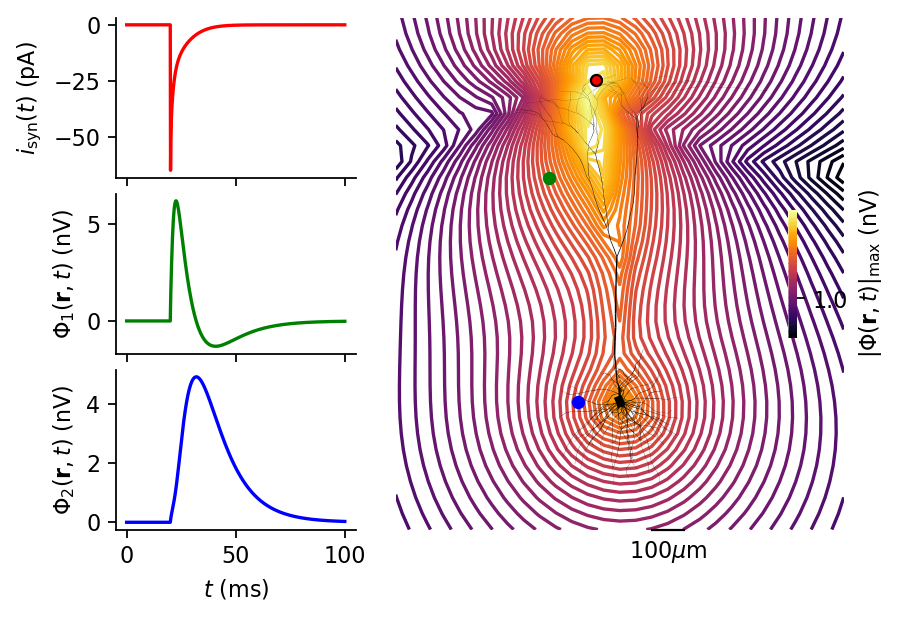

In [11]:
fig = plt.figure(dpi=160)

ax = fig.add_axes([.4,.1,.55,.8], aspect='equal', frameon=False)
cax = fig.add_axes([0.85, 0.4, 0.01, 0.2], frameon=False)

LFP = np.max(np.abs(grid_electrode.LFP),1).reshape(X.shape)
im = ax.contour(X, Z, np.log10(LFP), 
            50,
           cmap='inferno',
           zorder=-2)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('$|\Phi(\mathbf{r}, t)|_\mathrm{max}$ (nV)')
cbar.outline.set_visible(False)
#get some log-linear tickmarks and ticklabels
ticks = np.arange(np.ceil(np.log10(LFP.min())), np.floor(np.log10(LFP.max())))
cbar.set_ticks(ticks)
cbar.set_ticklabels(np.round(10.**ticks * 1E6, decimals=1)) #mV -> nV

#plot morphology
zips = []
for x, z in cell.get_idx_polygons():
    zips.append(list(zip(x, z)))
polycol = PolyCollection(zips,
                         edgecolors='none',
                         facecolors='k')
ax.add_collection(polycol)

ax.plot([100, 200], [-400, -400], 'k', lw=1, clip_on=False)
ax.text(150, -470, r'100$\mu$m', va='center', ha='center')

ax.axis('off')


ax.plot(synapse.x, synapse.z, 'o', ms=5,
        markeredgecolor='k',
        markerfacecolor='r')

color_vec = ['blue','green']
for i in range(2):
    ax.plot(point_electrode_parameters['x'][i],
                    point_electrode_parameters['z'][i],'o',ms=6,
                    markeredgecolor='none',
                    markerfacecolor=color_vec[i])

plt.axes([.15,.10,.25,.25])
plt.plot(cell.tvec,point_electrode.LFP[0]*1e6,color=color_vec[0], clip_on=False)
plt.ylabel(r'$\Phi_2(\mathbf{r},t)$ (nV)')
plt.xlabel(r'$t$ (ms)')
plt.axis('tight')
ax = plt.gca()
for loc, spine in ax.spines.items():
    if loc in ['right', 'top']:
        spine.set_color('none')            
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')


plt.axes([.15,.375,.25,.25])
plt.plot(cell.tvec,point_electrode.LFP[1]*1e6,color=color_vec[1], clip_on=False)
plt.ylabel(r'$\Phi_1(\mathbf{r}, t)$ (nV)')
plt.axis('tight')
ax = plt.gca()
for loc, spine in ax.spines.items():
    if loc in ['right', 'top']:
        spine.set_color('none')            
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticklabels([])

plt.axes([.15,.65,.25,.25])
plt.plot(cell.tvec, synapse.i*1E3, color='red', clip_on=False)
plt.ylabel(r'$i_\mathrm{syn}(t)$ (pA)')
plt.axis('tight')
ax = plt.gca()
for loc, spine in ax.spines.items():
    if loc in ['right', 'top']:
        spine.set_color('none')            
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticklabels([])


In [12]:
grid_electrode.LFP.tofile("lfpsimuladotalcual01.tsv", sep='\t')

In [13]:
np.savetxt("otraves.tab", grid_electrode.LFP, delimiter='\t' )

In [14]:
np.shape(LFP)

(29, 33)

In [15]:
np.savetxt("maxabslfp.tab", LFP, delimiter='\t')

In [16]:
lfp2=grid_electrode.LFP.reshape(29,33,801)

In [17]:
zips

[[(5.067294154989233, 20.90029716987668),
  (18.127106556891434, -11.571858092693965),
  (-5.067294154989233, -20.90029716987668),
  (-18.127106556891434, 11.571858092693965)],
 [(1.592903042565639, 0.7246787578816882),
  (6.566926022828507, -10.208566460162135),
  (3.381122784510409, -11.65793105429362),
  (-1.5929001957524587, -0.7246858362497961)],
 [(5.82083803754651, -10.021622563819065),
  (8.087197544661024, -12.126854010400375),
  (6.39357027690692, -13.950106397218),
  (4.127210769792406, -11.84487495063669)],
 [(7.849915722163809, -12.636590960831127),
  (14.923301278500322, -23.364555408929398),
  (13.704237655740648, -24.16833389488552),
  (6.630852099404136, -13.44036944678725)],
 [(14.796816662339404, -23.36779593911456),
  (24.579007389718285, -35.22098809130322),
  (23.612912999280447, -36.018285516889016),
  (13.830722271901566, -24.165093364700358)],
 [(24.580229288585755, -35.19228153301916),
  (34.8288783521897, -46.80581325601293),
  (33.860340164016925, -47.660523

In [18]:
cell.tvec

array([  0.   ,   0.125,   0.25 ,   0.375,   0.5  ,   0.625,   0.75 ,
         0.875,   1.   ,   1.125,   1.25 ,   1.375,   1.5  ,   1.625,
         1.75 ,   1.875,   2.   ,   2.125,   2.25 ,   2.375,   2.5  ,
         2.625,   2.75 ,   2.875,   3.   ,   3.125,   3.25 ,   3.375,
         3.5  ,   3.625,   3.75 ,   3.875,   4.   ,   4.125,   4.25 ,
         4.375,   4.5  ,   4.625,   4.75 ,   4.875,   5.   ,   5.125,
         5.25 ,   5.375,   5.5  ,   5.625,   5.75 ,   5.875,   6.   ,
         6.125,   6.25 ,   6.375,   6.5  ,   6.625,   6.75 ,   6.875,
         7.   ,   7.125,   7.25 ,   7.375,   7.5  ,   7.625,   7.75 ,
         7.875,   8.   ,   8.125,   8.25 ,   8.375,   8.5  ,   8.625,
         8.75 ,   8.875,   9.   ,   9.125,   9.25 ,   9.375,   9.5  ,
         9.625,   9.75 ,   9.875,  10.   ,  10.125,  10.25 ,  10.375,
        10.5  ,  10.625,  10.75 ,  10.875,  11.   ,  11.125,  11.25 ,
        11.375,  11.5  ,  11.625,  11.75 ,  11.875,  12.   ,  12.125,
        12.25 ,  12.

In [19]:
with open('cell.dat', 'a') as f:
  for z in zips:
    for y in z:
        punto=str(y[0])+'\t'+str(y[1])+'\n'
        f.write(punto)
    f.write('\n')

In [20]:
for z in zips:
    for y in z:
        print(y[0], "\t",y[1])
    print("\n")

5.067294154989233 	 20.90029716987668
18.127106556891434 	 -11.571858092693965
-5.067294154989233 	 -20.90029716987668
-18.127106556891434 	 11.571858092693965


1.592903042565639 	 0.7246787578816882
6.566926022828507 	 -10.208566460162135
3.381122784510409 	 -11.65793105429362
-1.5929001957524587 	 -0.7246858362497961


5.82083803754651 	 -10.021622563819065
8.087197544661024 	 -12.126854010400375
6.39357027690692 	 -13.950106397218
4.127210769792406 	 -11.84487495063669


7.849915722163809 	 -12.636590960831127
14.923301278500322 	 -23.364555408929398
13.704237655740648 	 -24.16833389488552
6.630852099404136 	 -13.44036944678725


14.796816662339404 	 -23.36779593911456
24.579007389718285 	 -35.22098809130322
23.612912999280447 	 -36.018285516889016
13.830722271901566 	 -24.165093364700358


24.580229288585755 	 -35.19228153301916
34.8288783521897 	 -46.80581325601293
33.860340164016925 	 -47.66052379816684
23.611691100412976 	 -36.04699207517307


34.930744464238806 	 -46.819495097

-57.90103637050013 	 -19.539695035530052
-58.43862573558058 	 -18.71294336697882
-46.95555127375213 	 -11.246156248274223


-57.781999824719286 	 -19.502328351373222
-66.82525720380795 	 -28.82991417274889
-67.60091966045007 	 -28.077895872511316
-58.557662281361424 	 -18.75031005113565


-66.91315955897348 	 -28.739651317859717
-75.97953482250027 	 -38.2560221747758
-76.57939256881134 	 -37.68452958431657
-67.51301730528455 	 -28.16815872740049


-75.91801950020293 	 -38.27827557301027
-84.56543076713085 	 -48.426196738034356
-85.28831915803663 	 -47.810197351106204
-76.64090789110871 	 -37.66227618608212


-84.42492491804299 	 -48.61732218450708
-92.60728738299106 	 -56.84599446546906
-93.61118747207256 	 -55.84774418559546
-85.42882500712449 	 -47.61907190463348


-92.94922075459512 	 -56.50412463647733
-99.50636440677648 	 -63.176410010397426
-99.82639775264987 	 -62.86189938850729
-93.2692541004685 	 -56.18961401458719


-99.46489419926566 	 -63.226859347229855
-106.3265169611702 

46.87677009795474 	 -12.713914245376346


56.35768136719581 	 -25.905042382423208
61.41802260886918 	 -41.50923994010817
60.75646556720302 	 -41.72377864799668
55.69612432552965 	 -26.11958109031171


61.49575536571611 	 -41.55976111687852
63.76286867633775 	 -57.87995678288441
62.94584612097774 	 -57.99345313723223
60.678732810356095 	 -41.673257471226336


63.875189350821564 	 -57.892271149519985
65.24853367453883 	 -73.98995884384155
64.2068697702112 	 -74.07882646491822
62.83352544649393 	 -57.98113877059666


65.08058029497506 	 -73.99706490985703
66.8344901520859 	 -90.57768650265784
66.12873300688584 	 -90.65234199170358
64.374823149775 	 -74.07172039890277


66.73149226393875 	 -90.66503397537903
63.673703519690335 	 -105.94065365278911
63.1739421507846 	 -105.84061419639247
66.231730895033 	 -90.56499451898239


63.984926540142425 	 -105.93727858256878
62.72393046559883 	 -121.10620895892504
61.601723055788916 	 -121.01291964296905
62.86271913033251 	 -105.8439892666128


47.4

16.287552307774316 	 -16.219865698485137
31.198202134841342 	 -26.157575720289366
30.44707772847438 	 -27.284571071867155
15.536427901407352 	 -17.346861050062927


31.18872595684258 	 -26.30717598410898
44.48993721896829 	 -38.071896951862314
43.757765168598844 	 -38.899691775800875
30.456553906473143 	 -27.13497080804754


44.56056679048841 	 -38.250411813409826
53.15470601498855 	 -54.19549624242524
52.28127482157886 	 -54.66626134326878
43.68713559707872 	 -38.72117691425336


53.09347468803943 	 -54.26980758082992
60.196770340651945 	 -70.82879256380077
59.44580180114051 	 -71.15093498783499
52.342506148527995 	 -54.59195000486413


60.470582903369 	 -70.68948247109975
68.06782934476401 	 -87.11150332403405
66.76923567981846 	 -87.7122659334703
59.17198923842346 	 -71.29024508053601


67.83968852976582 	 -87.18836845532718
76.21912847157029 	 -102.97716575120617
75.37681643662111 	 -103.42419809805617
66.99737649481665 	 -87.63540080217717


76.13120708956149 	 -102.99012216606613

-12.177037378044036 	 1021.9984550618922
-11.984277866791503 	 1021.704887947252
-19.52235951699116 	 1016.755297675686


-69.83883483954102 	 832.6481941332121
-71.2961598467943 	 846.6846489334998
-70.8574761061684 	 846.7301949630769
-69.40015109891513 	 832.6937401627891


-71.41111476915353 	 846.685378794871
-72.35148423328711 	 860.946609474272
-71.68289064794276 	 860.9906957811068
-70.74252118380917 	 846.7294651017057


-72.38162812508054 	 860.9590791410889
-72.76571432028591 	 875.5803599465785
-72.0368329513547 	 875.5995069197795
-71.65274675614933 	 860.9782261142899


-72.61020325408674 	 875.5649880991826
-74.31309203255859 	 889.8275312460567
-73.89523279602571 	 889.8774219140494
-72.19234401755386 	 875.6148787671754


-74.42845215052861 	 889.7630736125586
-78.06579425141862 	 902.9567375764884
-77.41721477894569 	 903.1355435114772
-73.77987267805568 	 889.9418795475474


-78.0458343291246 	 902.9231622202632
-83.363338772702 	 916.0821896732774
-82.7546791448171 

-243.8985570441088 	 930.9675956008174
-239.21411198539252 	 924.5605712553192


-244.2209384171141 	 930.8176307235523
-246.40855619432816 	 938.1424537609224
-246.012048047756 	 938.2608741331043
-243.82443027054194 	 930.9360510957341


-246.35632374472138 	 938.1673464994655
-247.7840842566489 	 944.2425042712017
-247.4920410092903 	 944.3111391662975
-246.06428049736277 	 938.2359813945612


-92.89262640721905 	 686.4633640166583
-97.24315964897666 	 706.1220903087528
-96.40080577707742 	 706.3085056678442
-92.05027253531982 	 686.6497793757496


-97.402187965202 	 706.1634602762941
-99.17513292780578 	 726.0075455830114
-98.01472242345585 	 726.1112210070202
-96.24177746085208 	 706.2671357003029


-99.23414726268236 	 726.049217218565
-99.56150835982119 	 746.6329327102768
-98.2830691857181 	 746.6532648631784
-97.95570808857927 	 726.0695493714666


-99.23311292942871 	 746.621241862586
-100.6900929477972 	 767.3407439546511
-100.06844463447906 	 767.3844578029343
-98.611464616

144.82128357196862 	 983.5831560025281


157.50640572870822 	 988.8434116064763
170.58663078539786 	 992.9255022907773
170.67600398273487 	 992.6391241513352
157.59577892604523 	 988.5570334670341


170.61640394569093 	 992.9669119379563
183.83712723003674 	 994.0349932620875
183.8669541067876 	 993.6657958282874
170.6462308224418 	 992.5977145041562


183.81148020363437 	 993.9948066308491
195.83366808052517 	 997.3714321099316
195.91478901008077 	 997.0826079386082
183.89260113318997 	 993.7059824595258


195.8493200780244 	 997.4877700103964
208.01105072197 	 998.6495344817806
208.06086765652717 	 998.1280345095277
195.89913701258155 	 996.9662700381434


208.00914093650172 	 998.6559931604137
221.39435353736872 	 999.9993927650769
221.44799004286244 	 999.4649754355578
208.06277744199545 	 998.1215758308946


221.41778988161005 	 999.8821459770827
234.73526317286752 	 1000.1824788161166
234.74202698987858 	 999.8825550625859
221.4245536986211 	 999.582222223552


234.73629050144126

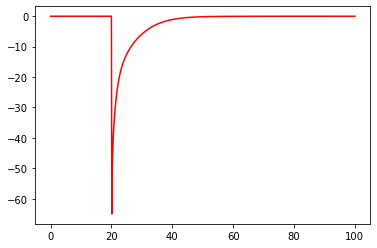

In [21]:
plt.plot(cell.tvec, synapse.i*1E3, color='red', clip_on=False)
